**Run the following two cells before you begin.**

In [ ]:
%autosave 10

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings(action="ignore")

**First, import the cleaned data set. Then, select the features from the DataFrame of the case study data.**
    
These features should be: `'LIMIT_BAL'`, `'EDUCATION'`, `'MARRIAGE'`, `'AGE'`, `'PAY_1'`, `'BILL_AMT1'`, `'BILL_AMT2'`, `'BILL_AMT3'`, `'BILL_AMT4'`, `'BILL_AMT5'`, `'BILL_AMT6'`, `'PAY_AMT1'`, `'PAY_AMT2'`, `'PAY_AMT3'`, `'PAY_AMT4'`, `'PAY_AMT5'`, AND `'PAY_AMT6'`.

In [4]:
# Import data set
data = pd.read_csv("cleaned_data.csv")

In [5]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,EDUCATION_CAT,graduate school,high school,others,university
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,1,university,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,1000,1000,0,2000,1,university,0,0,0,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,1000,1000,1000,5000,0,university,0,0,0,1
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,1200,1100,1069,1000,0,university,0,0,0,1
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,10000,9000,689,679,0,university,0,0,0,1


In [6]:
data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'EDUCATION_CAT', 'graduate school',
       'high school', 'others', 'university'],
      dtype='object')

In [7]:
data.dtypes

ID                            object
LIMIT_BAL                      int64
SEX                            int64
EDUCATION                      int64
MARRIAGE                       int64
AGE                            int64
PAY_1                          int64
PAY_2                          int64
PAY_3                          int64
PAY_4                          int64
PAY_5                          int64
PAY_6                          int64
BILL_AMT1                      int64
BILL_AMT2                      int64
BILL_AMT3                      int64
BILL_AMT4                      int64
BILL_AMT5                      int64
BILL_AMT6                      int64
PAY_AMT1                       int64
PAY_AMT2                       int64
PAY_AMT3                       int64
PAY_AMT4                       int64
PAY_AMT5                       int64
PAY_AMT6                       int64
default payment next month     int64
EDUCATION_CAT                 object
graduate school                int64
h

In [8]:
# Create features list
features = ["LIMIT_BAL","EDUCATION","MARRIAGE","AGE","PAY_1","BILL_AMT1","BILL_AMT2","BILL_AMT3",
            "BILL_AMT4","BILL_AMT5",'BILL_AMT6','PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5','PAY_AMT6']

_____________________________________________________
**Next, make a 80:20 train/test split using a random seed of 24.**

In [9]:
X = data[features].values
y = data["default payment next month"].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=24)

In [11]:
X_train.shape , y_test.shape

((21331, 17), (5333,))

In [12]:
C_val_exponents = np.linspace(3,-3,13)
print(C_val_exponents)

C_vals = np.float(10)**C_val_exponents
print(C_vals)

[ 3.   2.5  2.   1.5  1.   0.5  0.  -0.5 -1.  -1.5 -2.  -2.5 -3. ]
[1.00000000e+03 3.16227766e+02 1.00000000e+02 3.16227766e+01
 1.00000000e+01 3.16227766e+00 1.00000000e+00 3.16227766e-01
 1.00000000e-01 3.16227766e-02 1.00000000e-02 3.16227766e-03
 1.00000000e-03]


In [13]:
def cross_val_C_search(k_folds, C_vals, model, X, Y):
    
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    
    cv_test_roc = [[]]*len(C_vals)
    
    for c_val_counter in range(len(C_vals)):
        
        #Set the C value for the model object
        model.C = C_vals[c_val_counter]
        
        #Count folds for each value of C
        fold_counter = 0
        
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]
            
            #Fit the model on the training data
            model.fit(X_cv_train, y_cv_train)
            
            #Get the training ROC AUC
            y_cv_train_predict_proba = model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])
            
            
            #Get the testing ROC AUC
            y_cv_test_predict_proba = model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])
            
            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)
            
            #Increment the fold counter
            fold_counter += 1
            
        #Indicate progress
        print('Done with C = {}'.format(lr_syn.C))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [14]:
from sklearn.datasets import make_classification

X_synthetic, y_synthetic = make_classification(
    n_samples=1000, n_features=200,
    n_informative=3, n_redundant=10,
    n_repeated=0, n_classes=2,
    n_clusters_per_class=2, weights=None,
    flip_y=0.01, class_sep=0.8,
    hypercube=True, shift=0.0,
    scale=1.0, shuffle=True,
    random_state=24
)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(
    X_synthetic, y_synthetic,
    test_size=0.2, random_state=24
)

lr_syn = LogisticRegression(solver='liblinear', penalty='l1', C=1000, random_state=1)

n_folds = 4

k_folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)

cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search(k_folds, C_vals, lr_syn, X_syn_train, y_syn_train)

Done with C = 1000.0
Done with C = 316.22776601683796
Done with C = 100.0
Done with C = 31.622776601683793
Done with C = 10.0
Done with C = 3.1622776601683795
Done with C = 1.0
Done with C = 0.31622776601683794
Done with C = 0.1
Done with C = 0.03162277660168379
Done with C = 0.01
Done with C = 0.0031622776601683794
Done with C = 0.001


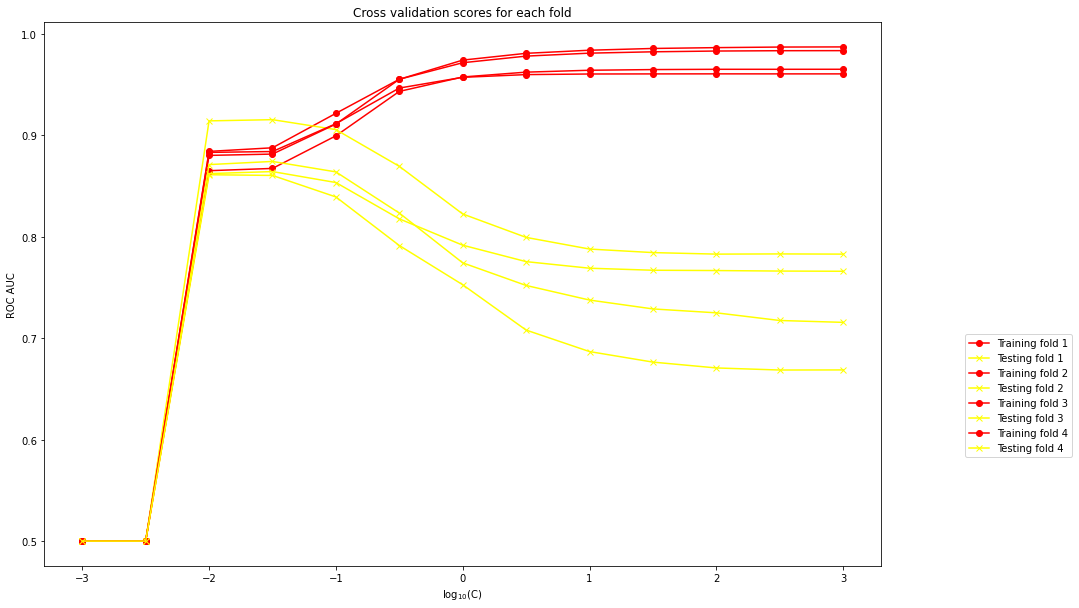

In [15]:
plt.figure(figsize = (15,10))

for this_fold in range(n_folds):
    plt.plot(C_val_exponents, cv_train_roc_auc[this_fold], '-o',
             color='red', label='Training fold {}'.format(this_fold+1))
    plt.plot(C_val_exponents, cv_test_roc_auc[this_fold], '-x',
             color='yellow', label='Testing fold {}'.format(this_fold+1))
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend(loc = [1.1, 0.2])
plt.title('Cross validation scores for each fold')
plt.show()


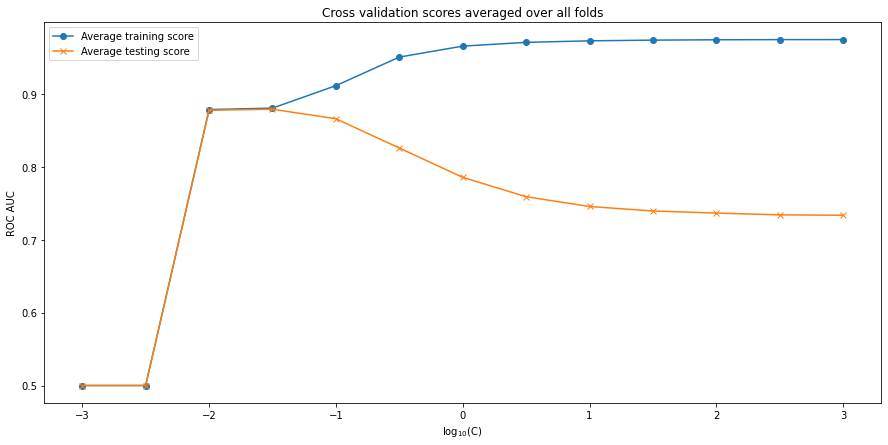

In [16]:
plt.figure(figsize = (15,7))
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')
plt.show()

_____________________________________________________
**Then, instantiate the `MinMaxScaler` to scale the data.**

In [17]:
scaler = MinMaxScaler()

_____________________________________________________
**Next, instantiate a logistic regression model with the `saga` solver, L1 penalty, and set `max_iter` to 1,000 as we want the solver to have enough iterations to find a good solution.**

In [18]:
regressor = LogisticRegression(solver="saga",  penalty = 'l1',max_iter=1000)

_____________________________________________________
**Next, import the `Pipeline` class and create a `Pipeline` with the scaler and the logistic regression model, using the names `'scaler'` and `'model'` for the steps, respectively.**

In [19]:
from sklearn.pipeline import Pipeline
scaler_pipeline = Pipeline(steps=[('scaler', scaler),("model", regressor)])

_____________________________________________________
**Now, use the `get_params` method to view the parameters from each stage of the pipeline.**

In [20]:
# Use `get_params`
scaler_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('model', LogisticRegression(max_iter=1000, penalty='l1', solver='saga'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': LogisticRegression(max_iter=1000, penalty='l1', solver='saga'),
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 1000,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l1',
 'model__random_state': None,
 'model__solver': 'saga',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

**Use the `set_params` method to change the the `model__C` parameter to 2.**

In [21]:
# View what `model__C` is set to currently
scaler_pipeline.get_params()['model__C']

1.0

In [22]:
# Change `model__C` to 2
scaler_pipeline.set_params(model__C = 2.0)
scaler_pipeline.get_params()["model__C"]

2.0

_____________________________________________________
**Then, create a smaller range of C values to test with cross-validation, as these models will take longer to train and test with more data than our previous activities.**

**Use C_vals = [$10^2$, $10$, $1$, $10^{-1}$, $10^{-2}$, $10^{-3}$].**


<details>
    <summary>Hint:</summary>
    Recall that exponents in Python use the ** operator.
</details>

In [23]:
C_exp = np.linspace(2,-3,6)
print(C_exp)

C_vals = np.float(10)**C_exp
print(C_vals)

[ 2.  1.  0. -1. -2. -3.]
[1.e+02 1.e+01 1.e+00 1.e-01 1.e-02 1.e-03]


Now, define `k_folds` using `StratifiedKFold`. The number of folds should be 4. Set the random state to 1.

In [24]:
k_folds = StratifiedKFold(n_splits=4,random_state=1)

_____________________________________________________
**Next, make a new version of the `cross_val_C_search` function, called `cross_val_C_search_pipe`. Instead of the model argument, this function will take a pipeline argument. The changes inside the function will be to set the `C` value using `set_params(model__C = <value you want to test>)` on the pipeline, replacing the model with the pipeline for the fit and `predict_proba` methods, and accessing the `C` value using `pipeline.get_params()['model__C']` for the printed status update.**

In [25]:
def cross_val_C_search_pipe(k_folds, C_vals, pipeline_model, X, Y):
    
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    
    cv_test_roc = [[]]*len(C_vals)
    
    for c_val_counter in range(len(C_vals)):
        
        #Set the C value for the model object
        pipeline_model.set_params(model__C = C_vals[c_val_counter])
        
        #Count folds for each value of C
        fold_counter = 0
        
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            
            #Subset the features and response, for training and testing data for this fold
            X_cv_train = X[train_index] 
            X_cv_test =  X[test_index]
            y_cv_train= Y[train_index] 
            y_cv_test =Y[test_index]
            
            
            #Fit the model on the training data
            pipeline_model.fit(X_cv_train, y_cv_train)
            
            #Get the training ROC AUC
            y_cv_train_predict_proba = pipeline_model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])
            
            
            #Get the testing ROC AUC
            y_cv_test_predict_proba = pipeline_model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])
            
            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)
            
            #Increment the fold counter
            fold_counter += 1
            
        #Indicate progress
        print('Done with C = {}'.format(pipeline_model.get_params()['model__C']))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

_____________________________________________________
**Now, run this function as in the previous activity, but using the new range of `C` values, the pipeline you created, and the features and response variable from the training split of the case study data.**

    You may see warnings here, or in later steps, about the non-convergence of the solver; you could experiment with the `tol` or `max_iter`` options to try and achieve convergence, although the results you obtain with `max_iter = 1000` are likely to be sufficient.

In [26]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds, C_vals, scaler_pipeline, X_train, y_train)

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


_____________________________________________________
**Plot the average training and testing ROC AUC across folds, for each `np.log(C_vals)` value.**

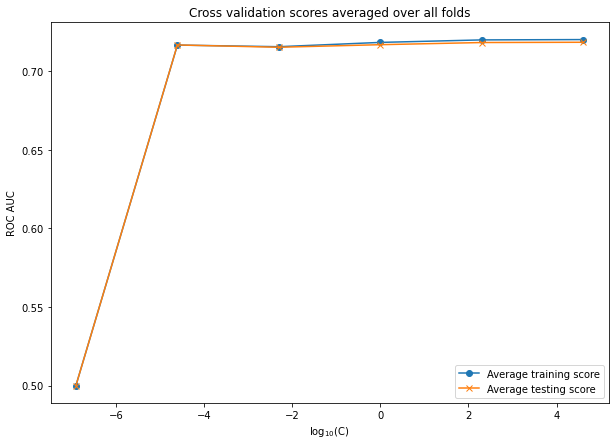

In [39]:
plt.figure(figsize = (10,7))
plt.plot(np.log(C_vals), np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(np.log(C_vals), np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')
plt.show()

_____________________________________________________
**Up next, create interaction features for the case study data using scikit-learn's `PolynomialFeatures`. You should use 2 as the degree of polynomial features. Confirm that the number of new features makes sense.**

In [41]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
poly_x = poly.fit_transform(X)
poly_x.shape

(26664, 171)

_____________________________________________________
**Finally, repeat the cross-validation procedure and observe the model performance now.**

In [42]:
# Using the new features, make a 80:20 train/test split using a random seed of 24.**
X_train, X_test, y_train, y_test = train_test_split(poly_x, y, test_size=0.2, random_state=None)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21331, 171)
(5333, 171)
(21331,)
(5333,)


In [43]:
# Call the cross_val_C_search_pipe() function using the new training data.
# All other parameters should remain the same.
# Note that this training may take a few minutes due to the larger number of features.
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds, C_vals, scaler_pipeline,X_train, y_train)

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


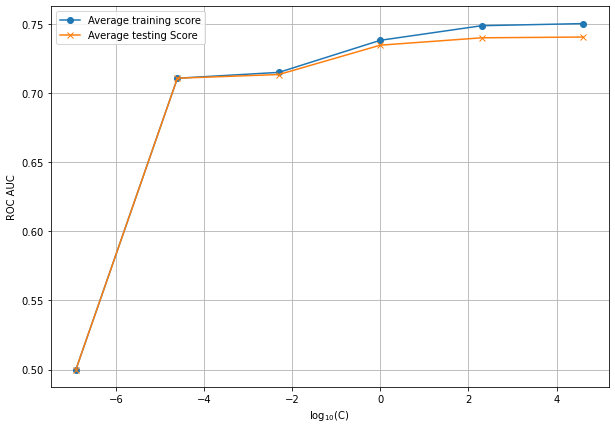

In [48]:
# Plot the average training and testing ROC AUC across folds, for each C value.
plt.figure(figsize=(10,7))
plt.plot(np.log(C_vals), np.mean(cv_train_roc_auc, axis=0), '-o', label="Average training score")
plt.plot(np.log(C_vals), np.mean(cv_test_roc_auc, axis=0), '-x', label="Average testing Score")
plt.xlabel("log$_{10}$(C)")
plt.ylabel("ROC AUC")
plt.legend()
plt.grid()
plt.show()

**Take a look at the above graph. Does the average cross-validation testing performance improve with the interaction features? Is regularization useful?**

After comparing two graphs, one without interaction features and one with interaction features, we observed that there is slight increase in ROC AUC score in the cross validation graph with interaction features.

Author: Purvit Vashishtha